# Clean Stanford Meter Data
Code author: Sahar H. El Abbadi
Date started: 2022-03-11
Date last edited: 2022-03-28

## Data description:
Stanford metering data, cleaned according to data processing pipeline. Includes 30-s, 60-s, and 90-s average flow rates, percent methane, and whole gas measurements. Each measurement is provided for the three different timestamp metrics: Stanford timestamps, as observed from the field; operator reported timestamps; and FlightRadar timestamps.

## Script objective:
- Load gas flow data for each flight day and assign methane mole fraction based on KM data
- Make "operator_meter" datasets for each method of using timestamp. Use whole-gas measurements from cleaned meter data, assign appropriate methane mole fraction, and calculate average and standard deviation of the release rate in kgh CH4 for each airplane overpass

In [2]:
import pandas as pd

# Setup

# Imports
from methods_source import load_summary_files, make_operator_meter_dataset, generate_daily_releases, load_flight_days


In [2]:
# Clean whole gas raw meter files:
## > load individual files for each day
## > for each data entry, provide the following: meter used for release, uncertainty of the meter for the given flow rate (as percent of flow rate), sigma of the meter reading based on the provided uncertainty (kgh whole gas), fraction methane, whole gas reading in kgh, sigma value associated with the methane fraction, calculated flow rate of methane in kgh, stanford data processing QC flag


import pathlib
from methods_source import sum_of_quadrature

from methods_source import select_methane_fraction, calc_meter_uncertainty
all_days = ['10_10', '10_11', '10_12', '10_13', '10_14', '10_17', '10_18', '10_19', '10_24', '10_25', '10_26', '10_27', '10_28', '10_29', '10_30', '10_31', '11_01', '11_02', '11_03', '11_04', '11_07', '11_08', '11_10', '11_11', '11_14', '11_15', '11_16', '11_17', '11_18', '11_21', '11_22', '11_23', '11_28', '11_29', '11_30']
gas_comp_sources = ['km', 'su_normalized', 'su_raw']

for gas_comp in gas_comp_sources:
    for day in all_days:
        # Load raw whole gas file for the selected day
        print(f'Preparing {day} data with {gas_comp} gas composition...')
        month = day[0:2]
        date = day[3:5]
        col_names = ['datetime_utc', 'whole_gas_kgh', 'meter', 'data_qc']
        daily_file = pd.read_excel(pathlib.PurePath('02_meter_data', 'daily_meter_data', 'whole_gas_raw', f'{month}_{date}.xlsx'), names=col_names, parse_dates = [0])

        # Abbreviate meter names in raw meter file to be compatible with other functions
        names = ['Baby Coriolis', 'Mama Coriolis', 'Papa Coriolis']
        nicknames = ['bc', 'mc', 'pc']
        for meter_name, meter_nickname in zip(names, nicknames):
            daily_file.loc[daily_file['meter'] == meter_name, 'meter'] = meter_nickname

        # Create storage array for new rows
        daily_log = []

        for index, row in daily_file.iterrows():
            meter = row['meter']
            whole_gas_kgh = row['whole_gas_kgh']
            datetime_utc = row['datetime_utc']
            fraction_methane, fraction_methane_sigma = select_methane_fraction(datetime_utc, gas_comp_source=gas_comp)
            data_qc = row['data_qc']

            # when meters aren't reading, set everything to pd.NA
            if (pd.isna(meter)) or (pd.isna(whole_gas_kgh)):
                meter = pd.NA
                meter_sigma = pd.NA
                whole_gas_kgh = pd.NA
                fraction_methane = pd.NA
                fraction_methane_sigma = pd.NA
                methane_kgh = pd.NA
                meter_percent_uncertainty = pd.NA
                kgh_ch4_sigma = pd.NA

            # for zero readings, set everything to 0
            elif whole_gas_kgh == 0:
                meter = 'None'
                meter_sigma = 0
                whole_gas_kgh = 0
                fraction_methane_sigma = 0
                methane_kgh = 0
                meter_percent_uncertainty = 0
                kgh_ch4_sigma = 0

            # for non-zero and non-NAN values, calculate all values:
            else:
                methane_kgh = whole_gas_kgh * fraction_methane
                meter_percent_uncertainty = calc_meter_uncertainty(meter, whole_gas_kgh)
                meter_sigma = meter_percent_uncertainty / 100 / 1.96 * whole_gas_kgh # sigma value of meter reading, as kgh whole gas

                # combine meter_sigma and fraction_methane_sigma to obtain ch4_kgh_sigma
                meter_relative_sigma = meter_sigma / whole_gas_kgh
                gas_comp_relative_sigma = fraction_methane_sigma / fraction_methane
                kgh_ch4_sigma = methane_kgh * sum_of_quadrature(gas_comp_relative_sigma, meter_relative_sigma)

            new_row = {
                'datetime_utc': datetime_utc,
                'meter': meter,
                'meter_percent_uncertainty': meter_percent_uncertainty,
                'meter_sigma': meter_sigma,
                'whole_gas_kgh': whole_gas_kgh,
                'fraction_methane': fraction_methane,
                'fraction_methane_sigma': fraction_methane_sigma,
                'methane_kgh': methane_kgh,
                'methane_kgh_sigma': kgh_ch4_sigma,
                'data_qc': data_qc,
            }

            daily_log.append(new_row)

        daily_meter_file = pd.DataFrame(daily_log)
        daily_meter_file.to_csv(pathlib.PurePath('02_meter_data', 'daily_meter_data', 'whole_gas_clean', f'{gas_comp}', f'{day}.csv'), na_rep='NA')
print('Data preparation complete')

Preparing 10_10 data with km gas composition...
Preparing 10_11 data with km gas composition...
Preparing 10_12 data with km gas composition...
Preparing 10_13 data with km gas composition...
Preparing 10_14 data with km gas composition...
Preparing 10_17 data with km gas composition...
Preparing 10_18 data with km gas composition...
Preparing 10_19 data with km gas composition...
Preparing 10_24 data with km gas composition...
Preparing 10_25 data with km gas composition...
Preparing 10_26 data with km gas composition...
Preparing 10_27 data with km gas composition...
Preparing 10_28 data with km gas composition...
Preparing 10_29 data with km gas composition...
Preparing 10_30 data with km gas composition...
Preparing 10_31 data with km gas composition...
Preparing 11_01 data with km gas composition...
Preparing 11_02 data with km gas composition...
Preparing 11_03 data with km gas composition...
Preparing 11_04 data with km gas composition...
Preparing 11_07 data with km gas composi

### Load daily metered release rates
This is all the metered data for releases conducted on flight days for each airplane operator. Includes the metered flow rate, then assigns methane mole fraction based on the measurement datetime, and calculates the methane mole fraction using the Kinder Morgan methane mole fraction data.

In [3]:
# Comment out to prevent from accidentally running
load_flight_days()
generate_daily_releases(gas_comp_sources=['km'])


Operator: Carbon Mapper
Flight Day: 10_10
Operator: Carbon Mapper
Flight Day: 10_11
Operator: Carbon Mapper
Flight Day: 10_12
Operator: Carbon Mapper
Flight Day: 10_28
Operator: Carbon Mapper
Flight Day: 10_29
Operator: Carbon Mapper
Flight Day: 10_31
Operator: GHGSat
Flight Day: 10_31
Operator: GHGSat
Flight Day: 11_02
Operator: GHGSat
Flight Day: 11_04
Operator: GHGSat
Flight Day: 11_07
Operator: Kairos
Flight Day: 10_24
Operator: Kairos
Flight Day: 10_25
Operator: Kairos
Flight Day: 10_26
Operator: Kairos
Flight Day: 10_27
Operator: Kairos
Flight Day: 10_28
Operator: Methane Air
Flight Day: 10_25
Operator: Methane Air
Flight Day: 10_29
Operator: Scientific Aviation
Flight Day: 11_08
Operator: Scientific Aviation
Flight Day: 11_10
Operator: Scientific Aviation
Flight Day: 11_11


### Make operator meter files
Operator meter files (saved in 02_meter_data > operator_meter_data) are meter files that used as input for creating the operator overpass summary dataframe (03_results > overpass_summary), which in turn is the input for all major analysis of airplane performance.

Operator meter files have the following columns:
- *datetime_utc*: datetime in UTC timezone, dtype is datetime object
- *overpass_id*: matches PerformerExperimentID in the operator report
- *phase_iii*: indicates if we provided the operator with the flow rate for this overpass in Phase III, with 1 meaning we gave the overpass and 0 meaning we did not
- *meter*: indicates which meter was used for measurement (bc = small Coriolis meter, mc = medium Coriolis meter, pc = large Coriolis meter)
- *qc_su_discard*: 0 if Stanford did NOT discard, 1 if Stanford QC does indicate this should be discarded, using lax criteria. Lax criteria is the standard for all analysis, we compare to strict in 07_qc_comparison.ipynb
- *qc_su_discard_strict*: indicates if Stanford would discard (1) with strict criteria, or keep (0) with strict criteria
- *altitude_feet*: flight altitude in feet, averaged for 60 seconds prior to the plane being directly over the release point. (Note: units in 02_meter_data > summary_files are tracking data, and are in the units reported by the tracking system. This is feet for FlightTracker and meters for Kairos' reporting system, both in units above sea level. The script clean_meter_column_names converts these to feet above ground level)
- *methane_fraction_km*: fraction methane using gas composition provided by Kinder Morgan. Suffix initials can also be "su_raw" and "su_normalized" if those methane mole fraction values are used in analysis
- *methane_fraction_km_sigma*: this is the standard deviation value (1-sigma) associated with gas compositional analysis, associated with the methane_fraction_km value provided
- *kgh_gas_60_mean*: average whole gas flow rate for the 60 seconds preceding the overpass time. Number will change with averaging period
- *kgh_gas_60_std*: standard deviation of gas calculated over the 60 seconds preceding the overpass timestamp
- *kgh_ch4_60_mean_km*: average methane flow rate averaged over 60 seconds, using Kinder Morgan gas composition
- *kgh_ch4_60_std_km*: standard deviation of the methane flow rate, over 60 seconds, using Kinder Morgan gas composition data

###### Scientific Aviation:
Note that Scientific Aviation submitted a report using non-standard template. The SciAv.csv summary file and sciav_1_overpasses overpass summary file were manually generated by Sahar El Abbadi.

#### Calculate uncertainty associated with each meter

##### Use Emerson sizing tool for meter uncertainty

Emerson reports uncertainty in instrument measurement as percentage of total flow rate. For now, assume these error bounds are the 95% confidence interval, representing 1.96 * standard deviation

###### Baby Corey
- If whole gas flow rate is greater than or equal to 4.84 kg/hr, uncertainty is 0.25% of flow rate
- If whole gas flow rate is less than 4.84 kg/hr, use the equation of best fit: $uncertainty = 1.1347 * (flow rate)^{-0.995}$ (see code below for determining this equation)

###### Mama Corey
- If whole gas flow rate is greater than or equal to 32.6 kg / hr, uncertainty is 0.25% of flow rate
- If whole gas flow rate is less than 32.6 kg / hr, uncertainty is determined using the following equation of best fit: $uncertainty = 7.6378 * (flow rate)^{-0.9922}$

###### Papa Corey
- If whole gas flow rate is greater than or equal to 350 kg / hr, uncertainty is 0.25% of the flow rate
- if whole gas flow rate is less than 350 kg/hr, uncertainty is a percentage of flow rate according to the following equation: $uncertainty = 78.3476 * (flow rate)^{-0.9912}$

In [1]:
# Load summary files, which include:
# > timestamps according to: operator, Stanford, Flightradar
# > overpass ID numbers according to: operator, Stanford, Flightradar
# > phase III: did we give the data point to operator as part of Phase III? 1 = yes
# > qc discard: was it discarded using the lax and strict discard, according to each timestsamp
# > average altitude: 60 seconds before being over release point, in feet above sea level for everyone but kairos and in meters above sealevel for Kairos

from methods_source import make_sciav_meter
from methods_source import load_summary_files, make_operator_meter_dataset, generate_daily_releases, load_flight_days

timekeepers = ['flightradar', 'stanford', 'team']
time_ave_operators = ['Carbon Mapper', 'GHGSat', 'Kairos', 'MethaneAir']
time_ave = [30, 60, 90]
gas_source = ['km'] # Note: gas sources here should make the m
# Dictionary of raw meter data

# Generate all datasets and save them
for timekeeper in timekeepers:
    for operator in time_ave_operators:
        for source in gas_source:
            for time in time_ave:
                make_operator_meter_dataset(operator, timekeeper, time, source)

# Make SciAv
operator='Scientific Aviation'
make_operator_meter_dataset('Scientific Aviation', gas_comp_source='km')
# cm_meter = make_operator_meter_dataset('Carbon Mapper', cm_meter_raw, 'flightradar', 60, 'km')
# ghg_meter = make_operator_meter_dataset('GHGSat', ghg_meter_raw, 'flightradar', 60, 'km')
# kairos_meter = make_operator_meter_dataset('Kairos', kairos_meter_raw, 'flightradar', 60, 'km')
# mair_meter = make_operator_meter_dataset('Methane Air', mair_meter_raw, 'flightradar', 60, 'km')



Making Carbon Mapper meter dataset, averaged over 30 seconds, using flightradar timestamps with km data for gas composition 
Making Carbon Mapper meter dataset, averaged over 60 seconds, using flightradar timestamps with km data for gas composition 
Making Carbon Mapper meter dataset, averaged over 90 seconds, using flightradar timestamps with km data for gas composition 
Number of rows that were NA in the average period (2022-10-12 17:51:51 to 2022-10-12 17:53:21): 1
Making GHGSat meter dataset, averaged over 30 seconds, using flightradar timestamps with km data for gas composition 
Making GHGSat meter dataset, averaged over 60 seconds, using flightradar timestamps with km data for gas composition 
Making GHGSat meter dataset, averaged over 90 seconds, using flightradar timestamps with km data for gas composition 
Number of rows that were NA in the average period (2022-10-31 20:30:54 to 2022-10-31 20:32:24): 3
Making Kairos meter dataset, averaged over 30 seconds, using flightradar ti

,datetime_utc,overpass_id,phase_iii,altitude,qc_stanford_discard,qc_stanford_discard_strict,gas_kgh_mean,gas_kgh_std,meter_sigma,methane_fraction_km,methane_fraction_km_sigma,ch4_kgh_mean_km,ch4_kgh_sigma
0,2022-11-08 21:36:22,1,0,NaN,0,0,604.096247,3.814360,0.770531,0.953370,0.001320,575.927315,3.794632
1,2022-11-08 22:32:13,2,0,NaN,0,0,240.914826,0.312002,0.307289,0.953370,0.001320,229.680998,0.524761
2,2022-11-08 23:05:50,3,0,NaN,0,0,7.442349,0.028764,0.009493,0.953370,0.001320,7.095313,0.030502
3,2022-11-08 23:45:18,4,0,NaN,0,0,113.445979,0.109333,0.144702,0.953370,0.001320,108.156007,0.228709
4,2022-11-10 18:05:56,5,0,NaN,0,1,1386.713324,197.705521,1.768767,0.953674,0.001663,1322.472443,188.568256
5,2022-11-10 18:46:34,6,0,NaN,0,0,210.222150,0.660400,0.268140,0.953674,0.001663,200.483398,0.764333
6,2022-11-10 19:26:04,7,0,NaN,0,0,359.156725,1.885788,0.458108,0.953674,0.001663,342.518430,1.944678
7,2022-11-10 20:04:59,8,0,NaN,0,0,0.000000,0.000000,0.000000,0.953674,0.000000,0.000000,0.000000
8,2022-11-10 20:47:38,9,0,NaN,0,0,83.941802,0.122820,0.107069,0.953674,0.001663,80.053114,0.208860
9,2022-11-10 21:25:50,10,0,NaN,0,0,123.904136,10.753984,0.158042,0.953674,0.001657,118.164153,10.258957


In [5]:
# Scientific Aviation meter dataset
import pandas as pd
import pathlib

sciav_clean_path = pathlib.PurePath('01_clean_reports', 'sciav_1_clean.csv')
sciav = pd.read_csv(sciav_clean_path, parse_dates={'start_utc': ['DateOfSurvey', 'StartUTC'],
                                                   'end_utc': ['DateOfSurvey', 'EndUTC']})


In [1]:
from methods_source import make_operator_meter_dataset
operator='Scientific Aviation'
make_operator_meter_dataset('Scientific Aviation', gas_comp_source='km')

Making SciAV operator meter dataset


,datetime_utc,overpass_id,phase_iii,altitude,altitude_feet,qc_su_discard,qc_su_discard_strict,gas_kgh_mean,gas_kgh_std,meter_sigma,methane_fraction_km,methane_fraction_km_sigma,ch4_kgh_mean_km,ch4_kgh_sigma
0,2022-11-08 21:36:22,1,0,NaN,NaN,0,0,604.096247,3.814360,0.770531,0.953370,0.001320,575.927315,3.794632
1,2022-11-08 22:32:13,2,0,NaN,NaN,0,0,240.914826,0.312002,0.307289,0.953370,0.001320,229.680998,0.524761
2,2022-11-08 23:05:50,3,0,NaN,NaN,0,0,7.442349,0.028764,0.009493,0.953370,0.001320,7.095313,0.030502
3,2022-11-08 23:45:18,4,0,NaN,NaN,0,0,113.445979,0.109333,0.144702,0.953370,0.001320,108.156007,0.228709
4,2022-11-10 18:05:56,5,0,NaN,NaN,0,1,1386.713324,197.705521,1.768767,0.953674,0.001663,1322.472443,188.568256
5,2022-11-10 18:46:34,6,0,NaN,NaN,0,0,210.222150,0.660400,0.268140,0.953674,0.001663,200.483398,0.764333
6,2022-11-10 19:26:04,7,0,NaN,NaN,0,0,359.156725,1.885788,0.458108,0.953674,0.001663,342.518430,1.944678
7,2022-11-10 20:04:59,8,0,NaN,NaN,0,0,0.000000,0.000000,0.000000,0.953674,0.000000,0.000000,0.000000
8,2022-11-10 20:47:38,9,0,NaN,NaN,0,0,83.941802,0.122820,0.107069,0.953674,0.001663,80.053114,0.208860
9,2022-11-10 21:25:50,10,0,NaN,NaN,0,0,123.904136,10.753984,0.158042,0.953674,0.001657,118.164153,10.258957


## Make plots of meter uncertainty

Figures showing what the meter uncertainty is across the range we used them

In [2]:
import numpy as np
from methods_source import calc_meter_uncertainty
meters = ['bc', 'mc', 'pc']
meter_min = {}
meter_max = {}
meter_range = {}
meter_uncertainty = {}

meter_min['bc'] = 0.56 # kgh
meter_max['bc'] = 30 # kgh
meter_min['mc'] = 3.87 # kgh
meter_max['mc'] = 300 # kgh
meter_min['pc'] = 40 # kgh
meter_max['pc'] = 2000 # kgh

for meter in meters:
    meter_range[meter] = np.linspace(meter_min[meter], meter_max[meter], 1000)
    store_uncertainty = []
    for flowrate in meter_range[meter]:
        uncertainty = calc_meter_uncertainty(meter, flowrate)
        store_uncertainty.append(uncertainty)

    meter_uncertainty[meter] = store_uncertainty

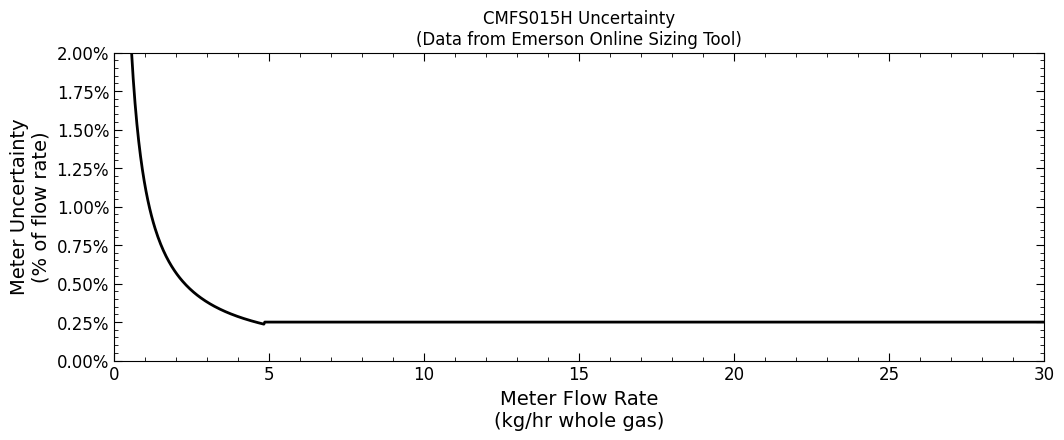

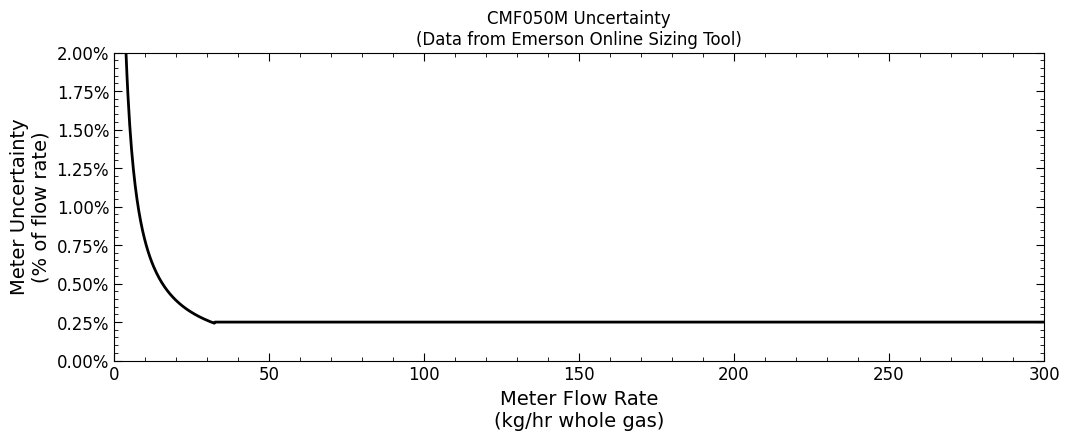

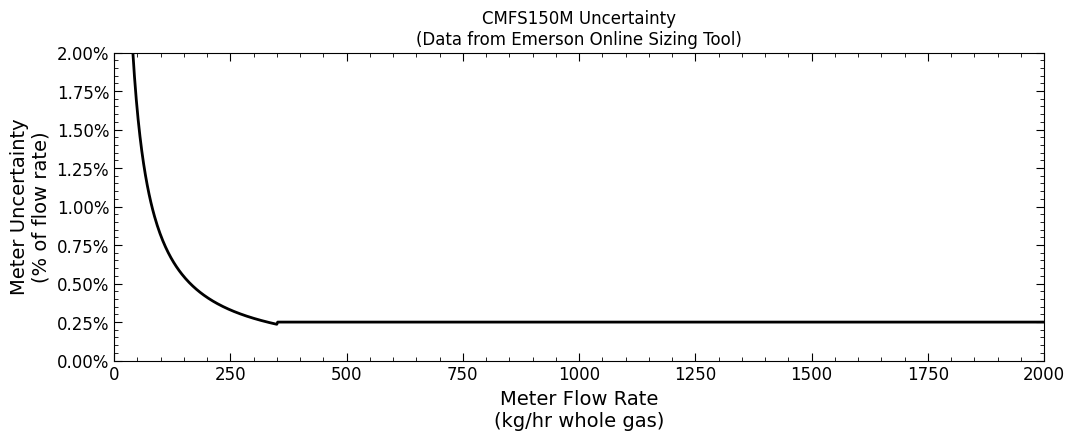

In [1]:
# import matplotlib.pyplot as plt
# import matplotlib.ticker as mtick
#
# ####### Calculate Uncertainty #######
#
# meters = ['bc', 'mc', 'pc']
# meter_min = {}
# meter_max = {}
# meter_range = {}
# meter_uncertainty = {}
#
# meter_min['bc'] = 0.56 # kgh
# meter_max['bc'] = 30 # kgh
# meter_min['mc'] = 3.87 # kgh
# meter_max['mc'] = 300 # kgh
# meter_min['pc'] = 40 # kgh
# meter_max['pc'] = 2000 # kgh
#
# for meter in meters:
#     meter_range[meter] = np.linspace(meter_min[meter], meter_max[meter], 1000)
#     store_uncertainty = []
#     for flowrate in meter_range[meter]:
#         uncertainty = calc_meter_uncertainty(meter, flowrate)
#         store_uncertainty.append(uncertainty)
#
#     meter_uncertainty[meter] = store_uncertainty
#
#
# ####### Plot #######
# x_data = meter_range[meter]
# y_data = meter_uncertainty[meter]
#
# # Name meter for plot
# meter_id ={}
# meter_id['bc'] = 'CMFS015H'
# meter_id['mc'] = 'CMF050M'
# meter_id['pc'] = 'CMFS150M'
#
# # Initialize figure
# fig, ax = plt.subplots(1, figsize=(12, 4))
# plt.plot(x_data, y_data, color='black',
#          linewidth=2)
#
# ax.set(xlim=(0, meter_max[meter]),
#        ylim=(0, 2)
#        )
#
# # title
# plt.title(f'{meter_id[meter]} Uncertainty\n(Data from Emerson Online Sizing Tool)')
#
# # Format axes
# plt.xlabel('Meter Flow Rate\n(kg/hr whole gas)', fontsize=14)
# plt.ylabel('Meter Uncertainty\n(% of flow rate)', fontsize=14)
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
# plt.tick_params(direction='in', right=True, top=True)
# plt.tick_params(labelsize=12)
# plt.minorticks_on()
# plt.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
# plt.tick_params(direction='in', which='minor', length=3, bottom=True, top=True, left=True, right=True)
# plt.tick_params(direction='in', which='major', length=6, bottom=True, top=True, left=True, right=True)

from plot_methods import plot_meter_uncertainty
meters = ['bc', 'mc', 'pc']
for meter in meters:
    plot_meter_uncertainty(meter)